# Multi-label Legal Text Classification for CIA

## Models and Experiments

### Preliminaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv

In [2]:
from zipfile import ZipFile
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
import gensim.downloader as api
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics.pairwise import cosine_similarity
from numpy.linalg import norm
import umap.umap_ as umap

In [3]:
os.chdir("../..")
os.getcwd()

'/Users/janinedevera/Documents/School/MDS 2021-2023/Thesis/multilabel-legal-text-classification-CIA'

In [4]:
text = pd.read_csv("data/01 legal_texts_pipeline.csv")

In [5]:
text

,Unnamed: 0,file_name,country,text,lang,length,text_clean
0,0,SG_Public Consultation Paper on Draft Amendmen...,SG,V: PROCEDURES AND TIMEFRAME FOR SUBMITTING CO...,en,233,v procedur and timefram for submit comment mci...
1,2,SG_Public Consultation Paper on Draft Amendmen...,SG,"6 of the PSA, and such providers would theref...",en,274,psa provid would therefor requir postal servic...
2,3,SG_Public Consultation Paper on Draft Amendmen...,SG,s 48 and 48A to expand the powers of search an...,en,90,48a expand power search arrest dispos letter r...
3,4,SG_Public Consultation Paper on Draft Amendmen...,SG,currently does not spell out the consequences...,en,86,current spell consequ breach direct given mini...
4,5,SG_Public Consultation Paper on Draft Amendmen...,SG,on the regulation of letter boxes. Enhancing ...,en,29,regul letter box enhanc enforc power psa today...
...,...,...,...,...,...,...,...
3952,7806,"BN_Companies Act Chapter 39, 2016",BN,OF NUMBER OF MEMBERS BELOW LEGAL MINIMUM 31. ...,en,22,of number of member below legal minimum prohib...
3953,7809,"BN_Companies Act Chapter 39, 2016",BN,AND ARTICLES 23. Effect of memorandum and art...,en,31,and articl effect memorandum articl money paya...
3954,7811,"BN_Companies Act Chapter 39, 2016",BN,OF COMPANIES 20. Restriction on registration ...,en,27,of compani restrict registr compani certain na...
3955,7816,"BN_Companies Act Chapter 39, 2016",BN,OF ASSOCIATION 4. Mode of forming incorporate...,en,43,of associ mode form incorpor compani requir re...


In [6]:
defs = pd.read_csv("data/01 oecd_definitions.csv")

In [7]:
defs

,Unnamed: 0,Main_Cat,Sub_Cat,Text,length,text_clean
0,0,A,A,Limiting the number of suppliers leads to the ...,118,limit number supplier lead risk market power c...
1,1,A,A1,Granting an exclusive right to produce a certa...,172,grant exclus right produc certain good provid ...
2,2,A,A2,Licenses or permits required for operation nec...,176,licens permit requir oper necessarili restrict...
3,3,A,A3,Governments can limit the ability of certain s...,71,govern limit abil certain supplier particip bu...
4,4,A,A4,"Regulations that raise the cost of entry to, o...",149,regul rais cost entri exit market tend discour...
5,5,A,A5,"Regulations sometimes limit the flow of goods,...",142,regul sometim limit flow good servic capit and...
6,6,B,B,Regulation can affect a supplier's ability to ...,50,regul affect supplier 's abil compet varieti w...
7,7,B,B1,Governments often regulate prices in tradition...,177,govern often regul price tradit monopoli secto...
8,8,B,B2,Regulations that restrict supplier's ability t...,141,regul restrict supplier 's abil advertis marke...
9,9,B,B3,Regulations setting standards often provide be...,193,regul set standard often provid benefit consum...


### I. Pre-Trained Word Embeddings

#### A. GloVe

##### Document embedding matrix

In [92]:
# load GloVe embeddings
dims = 300
f = open(f'data/glove/glove.6B.{dims}d.txt') # download GloVe and save in data folder

embed_matrix = pd.read_table(
    f, sep = " ", index_col = 0, 
    header = None, quoting = csv.QUOTE_NONE
)

embed_matrix.shape

(400000, 300)

In [93]:
# document feature matrix 
vectorizer = TfidfVectorizer()
text_dfm = vectorizer.fit_transform(text['text_clean'])
text_dfm.shape

(3957, 10829)

In [94]:
# document embedding matrix
def doc_matrix(dfm):
    common_features = set(embed_matrix.index) & set(vectorizer.get_feature_names_out())
    vocab_ids = [vectorizer.vocabulary_[x] for x in common_features]
    matrix = dfm[:,vocab_ids].dot(embed_matrix.loc[common_features,])
    return matrix

In [95]:
text_doc_matrix = doc_matrix(text_dfm)
text_doc_matrix.shape

/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_55734/1503737854.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  matrix = dfm[:,vocab_ids].dot(embed_matrix.loc[common_features,])


(3957, 300)

In [96]:
defs_dfm = vectorizer.fit_transform(defs['text_clean'])
defs_dfm.shape

(18, 505)

In [98]:
defs_doc_matrix = doc_matrix(defs_dfm)
defs_doc_matrix.shape

/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_55734/1503737854.py:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  matrix = dfm[:,vocab_ids].dot(embed_matrix.loc[common_features,])


(18, 300)

##### Cosine similarities

In [99]:
def cos_sim(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

In [100]:
docs = []
for i in range(len(text_doc_matrix)):
    scores = []
    for j in range(len(defs_doc_matrix)):
        A = text_doc_matrix[i]
        B = defs_doc_matrix[j]
        scores += [(cos_sim(A,B)+1)/(1+1)] # centered 
    docs += [scores]

In [101]:
scores_df = pd.DataFrame(docs, columns = ["A", "A1", "A2", "A3", "A4", "A5",
                                   "B", "B1", "B2", "B3", "B4",
                                   "C", "C1", "C2", "C3",
                                   "D1", "D2", "D3"])

In [102]:
scores_df

,A,A1,A2,A3,A4,A5,B,B1,B2,B3,B4,C,C1,C2,C3,D1,D2,D3
0,0.878472,0.878373,0.896583,0.826655,0.871035,0.875192,0.855002,0.854243,0.877407,0.892135,0.875251,0.879628,0.878576,0.875328,0.848875,0.881012,0.872898,0.907295
1,0.854552,0.840158,0.882529,0.841466,0.870895,0.855248,0.853953,0.837029,0.867685,0.868617,0.862237,0.859432,0.873476,0.856893,0.845093,0.851226,0.851742,0.855663
2,0.871088,0.843893,0.874042,0.844152,0.874516,0.875603,0.869060,0.868521,0.851324,0.887944,0.872032,0.870637,0.881412,0.853884,0.857591,0.854753,0.853570,0.863468
3,0.881344,0.852856,0.886959,0.859507,0.877802,0.879161,0.880185,0.866065,0.860409,0.897168,0.877538,0.866631,0.886514,0.853792,0.855139,0.856606,0.879028,0.878354
4,0.886487,0.839401,0.876812,0.823139,0.859429,0.868762,0.861264,0.859265,0.833621,0.886639,0.887101,0.857925,0.879365,0.855495,0.839462,0.842558,0.876877,0.876377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3952,0.850380,0.820828,0.856978,0.837702,0.840123,0.867546,0.840383,0.860588,0.808367,0.866152,0.856999,0.827610,0.845249,0.835206,0.830421,0.836647,0.835412,0.834582
3953,0.793783,0.805595,0.825166,0.783915,0.778836,0.800209,0.779834,0.789568,0.792049,0.801657,0.800647,0.824109,0.819796,0.811023,0.828944,0.767436,0.780723,0.801196
3954,0.799791,0.781637,0.814314,0.767413,0.801416,0.809280,0.787403,0.789206,0.764392,0.817942,0.814695,0.784547,0.820500,0.760035,0.770257,0.798057,0.800242,0.815425
3955,0.729542,0.737423,0.778395,0.742421,0.774242,0.750517,0.742531,0.747311,0.736132,0.753209,0.742977,0.751476,0.754248,0.750473,0.730215,0.725753,0.739636,0.726420


In [18]:
text

,Unnamed: 0,file_name,country,text,lang,length,text_clean
0,0,SG_Public Consultation Paper on Draft Amendmen...,SG,V: PROCEDURES AND TIMEFRAME FOR SUBMITTING CO...,en,233,v procedur and timefram for submit comment mci...
1,2,SG_Public Consultation Paper on Draft Amendmen...,SG,"6 of the PSA, and such providers would theref...",en,274,psa provid would therefor requir postal servic...
2,3,SG_Public Consultation Paper on Draft Amendmen...,SG,s 48 and 48A to expand the powers of search an...,en,90,48a expand power search arrest dispos letter r...
3,4,SG_Public Consultation Paper on Draft Amendmen...,SG,currently does not spell out the consequences...,en,86,current spell consequ breach direct given mini...
4,5,SG_Public Consultation Paper on Draft Amendmen...,SG,on the regulation of letter boxes. Enhancing ...,en,29,regul letter box enhanc enforc power psa today...
...,...,...,...,...,...,...,...
3952,7806,"BN_Companies Act Chapter 39, 2016",BN,OF NUMBER OF MEMBERS BELOW LEGAL MINIMUM 31. ...,en,22,of number of member below legal minimum prohib...
3953,7809,"BN_Companies Act Chapter 39, 2016",BN,AND ARTICLES 23. Effect of memorandum and art...,en,31,and articl effect memorandum articl money paya...
3954,7811,"BN_Companies Act Chapter 39, 2016",BN,OF COMPANIES 20. Restriction on registration ...,en,27,of compani restrict registr compani certain na...
3955,7816,"BN_Companies Act Chapter 39, 2016",BN,OF ASSOCIATION 4. Mode of forming incorporate...,en,43,of associ mode form incorpor compani requir re...


In [19]:
text_scores_glove = pd.merge(text, scores_df, left_index=True, right_index=True)

In [202]:
text_scores_glove.to_csv("data/scores/sim_scores_glove.csv")

##### Dimensionality reduction

In [103]:
# df combining text and labels
df_comb = (text[['file_name', 'country', 'length']]
           .rename(columns = {'file_name':'name'})
           .append(defs[['Main_Cat', 'length']]
                   .rename(columns = {'Main_Cat':'name'})))
df_comb

/var/folders/rd/n9w0gpv53y72x5k9wk3hp63w0000gn/T/ipykernel_55734/762642827.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_comb = (text[['file_name', 'country', 'length']]


,name,country,length
0,SG_Public Consultation Paper on Draft Amendmen...,SG,233
1,SG_Public Consultation Paper on Draft Amendmen...,SG,274
2,SG_Public Consultation Paper on Draft Amendmen...,SG,90
3,SG_Public Consultation Paper on Draft Amendmen...,SG,86
4,SG_Public Consultation Paper on Draft Amendmen...,SG,29
...,...,...,...
13,C,NaN,135
14,C,NaN,60
15,D,NaN,75
16,D,NaN,92


In [104]:
#categories =["A", "A1", "A2", "A3", "A4", "A5", "B", "B1", "B2", "B3", "B4",
            #"C", "C1", "C2", "C3", "D1", "D2", "D3"]
categories = ["A", "B", "C", "D"]

df_comb['category'] = df_comb['name'].apply(lambda x: x if x in categories else 'text')

In [105]:
reducer = umap.UMAP()

# dfm combining embeddings 
def dfm_combined(df, dfm1, dfm2):
    dfm_comb = np.vstack((dfm1, dfm2))
    embed = reducer.fit_transform(dfm_comb)
    df["x"] = embed[:,0]
    df["y"] = embed[:,1]
    return df

In [106]:
df_comb = dfm_combined(df_comb, text_doc_matrix, defs_doc_matrix)

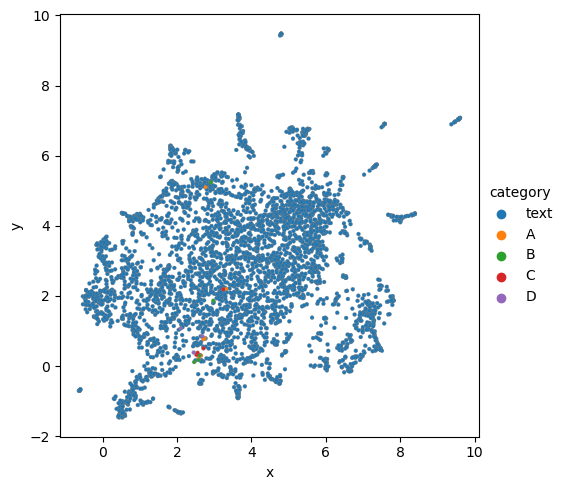

In [107]:
sns.relplot(
data=df_comb, x="x", y="y", hue="category", edgecolor="grey",
s=8, facet_kws={"despine": False}
)

In [108]:
df_comb.to_csv("data/02 embed_dim_reduced_glove.csv")

#### B. Legal Word2Vec

##### Document embedding matrix (from SigmaLaw word2vec trained from legal corpus)

In [47]:
w2v_law = KeyedVectors.load_word2vec_format("data/sigma-lemmatized-legal/legallemmatextreplacewithnnp.bin", binary=True, unicode_errors='ignore') 
w2v_law.vectors.shape

(52431, 200)

In [48]:
def doc_matrix_w2v(dfm):
    words = set(vectorizer.get_feature_names_out())
    text_vocab = list(words)

    common_features = []
    for word in text_vocab:
        if word in w2v_law:
            common_features += [word]

    embed_common=np.empty((0,200))
    for word in words:
        if word in w2v_law:
            embed_common=np.vstack([embed_common, w2v_law[word]])

    vocab_ids = [vectorizer.vocabulary_[x] for x in common_features]
    doc_matrix_w2v = dfm[:,vocab_ids].dot(embed_common)

    return doc_matrix_w2v
    

In [49]:
text_dfm = vectorizer.fit_transform(text['text_clean'])
text_doc_matrix = doc_matrix_w2v(text_dfm)
text_doc_matrix.shape

(3957, 200)

In [50]:
defs_dfm = vectorizer.fit_transform(defs['text_clean'])
defs_doc_matrix = doc_matrix_w2v(defs_dfm)
defs_doc_matrix.shape

(18, 200)

Full sample

In [51]:
# get corpus vocabulary
text_dfm = vectorizer.fit_transform(text['text_clean'])
words = set(vectorizer.get_feature_names_out())
text_vocab = list(words)

In [52]:
# get common features between vocab & w2v legal
common_features = []
for word in text_vocab:
    if word in w2v_law:
        common_features += [word]
len(common_features)

4510

In [53]:
# get embedding matrix of common features
embed_common=np.empty((0,200))
for word in words:
    if word in w2v_law:
        embed_common=np.vstack([embed_common, w2v_law[word]])
embed_common.shape

(4510, 200)

In [54]:
vocab_ids = [vectorizer.vocabulary_[x] for x in common_features] # vocab id of common features
text_doc_matrix = text_dfm[:,vocab_ids].dot(embed_common)
text_doc_matrix.shape

(3957, 200)

##### Cosine similarities

In [55]:
docs = []
for i in range(len(text_doc_matrix)):
    scores = []
    for j in range(len(defs_doc_matrix)):
        A = text_doc_matrix[i]
        B = defs_doc_matrix[j]
        scores += [(cos_sim(A,B)+1)/(1+1)] # centered 
    docs += [scores]

In [56]:
scores_df = pd.DataFrame(docs, columns = ["A", "A1", "A2", "A3", "A4", "A5",
                                   "B", "B1", "B2", "B3", "B4",
                                   "C", "C1", "C2", "C3",
                                   "D1", "D2", "D3"])

In [198]:
scores_df

,A,A1,A2,A3,A4,A5,B,B1,B2,B3,B4,C,C1,C2,C3,D1,D2,D3
0,0.536525,0.459559,0.537989,0.463001,0.523567,0.498330,0.455624,0.465707,0.517841,0.471030,0.507956,0.499249,0.498103,0.608890,0.344464,0.594111,0.527763,0.637100
1,0.665215,0.575294,0.729426,0.705163,0.676475,0.668700,0.618173,0.589117,0.657095,0.592675,0.713742,0.628497,0.714595,0.713065,0.554240,0.641008,0.662267,0.554308
2,0.580048,0.527133,0.670397,0.663248,0.586911,0.602800,0.585329,0.575341,0.615143,0.539514,0.630336,0.551113,0.647147,0.602205,0.612300,0.565240,0.562154,0.481261
3,0.567670,0.501511,0.570694,0.714365,0.539091,0.583048,0.613908,0.615573,0.568935,0.568260,0.646162,0.558265,0.623368,0.630092,0.595794,0.538882,0.599728,0.587790
4,0.678133,0.682478,0.729480,0.646756,0.682879,0.712383,0.605551,0.568417,0.706246,0.592776,0.707106,0.644615,0.691720,0.669281,0.657721,0.635652,0.601724,0.495907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3952,0.551197,0.452049,0.560255,0.653386,0.565066,0.555950,0.597086,0.665313,0.517814,0.574170,0.585063,0.554840,0.553634,0.599394,0.527647,0.546437,0.589858,0.498585
3953,0.584132,0.467479,0.534105,0.616220,0.504181,0.530071,0.540425,0.553892,0.530312,0.453443,0.605633,0.598396,0.530186,0.606739,0.508496,0.498931,0.569075,0.493146
3954,0.614141,0.568402,0.646899,0.650706,0.586871,0.618491,0.575393,0.569283,0.625319,0.538354,0.662443,0.559164,0.605036,0.632609,0.543255,0.584565,0.566902,0.532200
3955,0.560857,0.531230,0.617293,0.625084,0.545608,0.586323,0.577739,0.541715,0.565509,0.519056,0.604129,0.531622,0.611913,0.609999,0.572086,0.518065,0.511973,0.455983


In [199]:
text_scores_legalw2v = pd.merge(text, scores_df, left_index=True, right_index=True)

In [203]:
text_scores_legalw2v.to_csv("data/scores/sim_scores_legalw2v.csv")

##### Dimensionality reduction

In [57]:
df_comb = dfm_combined(df_comb, text_doc_matrix, defs_doc_matrix)

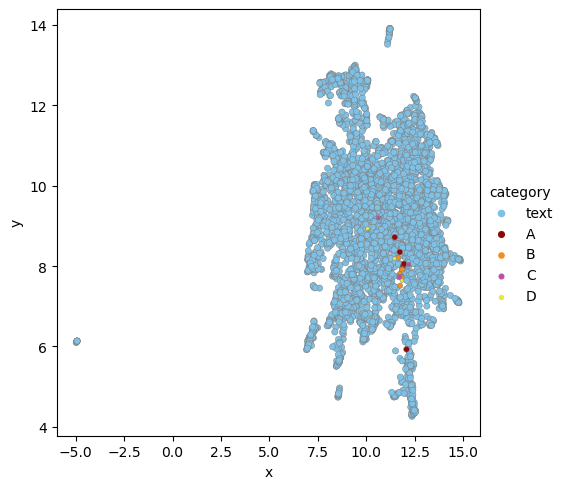

In [75]:
cdict = {
'text': '#7ec1e6',
'A': '#910707',
'B': '#f08e1f',
'C': '#ba50a5',
'D': '#ede732'
}

sns.relplot(
data=df_comb, x="x", y="y", hue="category", edgecolor="grey",
sizes = (8,20), size = "category", palette = cdict, facet_kws={"despine": False}
)

In [77]:
df_comb.to_csv("data/02 embed_dim_reduced_legal.csv")